In [1]:
import os
os.chdir('../')

In [36]:
import numpy as np

data = np.load('/data/score_sde_outputs/checkpoint_8/UniPC_bh1_200/samples_0.npz')
#data = np.load('/data/score_sde_outputs/checkpoint_8/UniPC_bh1_5/samples_0.npz')
target_traj, model_traj, x0_traj = data['hist']
timesteps, signal_rates, noise_rates = data['timesteps']
print(target_traj.shape, model_traj.shape, x0_traj.shape)
print(len(timesteps))

(201, 256, 3, 32, 32) (201, 256, 3, 32, 32) (201, 256, 3, 32, 32)
201


In [3]:
# ────────────────── 필수 라이브러리 ──────────────────
import torch, os, logging
from ml_collections import config_dict
from ml_collections.config_flags import config_flags
from omegaconf import OmegaConf   # ← YAML 계열 설정이라면 사용
from absl import flags

# ───────────── 코드베이스 내부 모듈 (이미 설치/복사돼 있다고 가정) ─────────────
from models import utils as mutils           # 모델 util
from models.ema import ExponentialMovingAverage
from models import ddpm, ncsnv2, ncsnpp      # 모델 정의를 registry에 등록만 해도 OK
import sde_lib                               # VPSDE / sub-VPSDE 등
from samplers.utils import NoiseScheduleVP
from utils import restore_checkpoint         # 개인 util
from models.utils import get_noise_fn

# ────────────────── 사용자 정의 경로 변수 ──────────────────
ckpt_path="/data/checkpoints/cifar10_ddpmpp_deep_continuous/checkpoint_8.pth"
config_path="configs/vp/cifar10_ddpmpp_deep_continuous_N=128_order=1.py"
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# reproducibility
torch.manual_seed(42)
logging.basicConfig(level=logging.INFO)


/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/logpx/miniconda3/envs/rbf/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [4]:
# ml_collections의 python-config 파일이라면 바로 import, YAML이면 OmegaConf.load 사용
import importlib.util, types, sys, pathlib

def load_config(path: str):
    path = pathlib.Path(path)
    if path.suffix == ".py":                       # 파이썬 config
        spec = importlib.util.spec_from_file_location("user_config", path)
        cfg_module = importlib.util.module_from_spec(spec)
        sys.modules["user_config"] = cfg_module
        spec.loader.exec_module(cfg_module)
        return cfg_module.get_config()
    else:                                         # YAML 등
        return OmegaConf.to_container(OmegaConf.load(path), resolve=True)

config = load_config(config_path)
config.device = device


In [5]:
# 모델 인스턴스 & EMA 래퍼
score_model = mutils.create_model(config).to(device)
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)

state = dict(model=score_model, ema=ema, step=0)

# 체크포인트 복원
state = restore_checkpoint(ckpt_path, state, device=device)
ema.copy_to(score_model.parameters())    # EMA 가중치 적용
score_model.eval()


NCSNpp(
  (act): SiLU()
  (all_modules): ModuleList(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3-10): 8 x ResnetBlockBigGANpp(
      (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Dense_0): Linear(in_features=512, out_features=128, bias=True)
      (GroupNorm_1): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Dropout_0): Dropout(p=0.1, inplace=False)
      (Conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU()
    )
    (11): ResnetBlockBigGANpp(
      (GroupNorm_0): GroupNorm(32, 128, eps=1e-06, affine=True)
      (Conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Dense_0): Linear(in_features=512, out_features=128, bias=True)
      (GroupNorm_1): 

In [6]:
if config.training.sde.lower() == "vpsde":
    sde = sde_lib.VPSDE(
        beta_min=config.model.beta_min,
        beta_max=config.model.beta_max,
        N=config.model.num_scales,
    )
else:
    raise NotImplementedError(f"SDE {config.training.sde} unsupported.")


In [7]:
# continuous=True → 연속-시간(ODE) 해석용
noise_pred_fn = get_noise_fn(
    sde        = sde,
    model      = score_model,
    train      = False,     # inference 모드
    continuous = True,
)

# 이제 noise_pred_fn(x, t) 형태로 바로 사용 가능합니다.


In [11]:
# 무작위 x_t 샘플 하나와 임의 t (예: 0.785)에서 노이즈 예측
x = torch.randn(1, config.data.num_channels,
                config.data.image_size,
                config.data.image_size, device=device)

t = torch.tensor([0.785], device=device)
with torch.no_grad():
    eps_hat = noise_pred_fn(x, t)      # shape: (1, C, H, W)
    
model_fn = lambda x, t: noise_pred_fn(x, t.expand((x.shape[0])))
print(eps_hat.mean().item())


0.0027310948353260756


In [37]:
import torch.nn.functional as F
from tqdm import tqdm

noise = torch.tensor(target_traj[0], device=device)
image = torch.tensor(target_traj[-1], device=device)
target_losses = []
model_losses = []
M = 10
for target_t, model_t, t, alpha, sigma in tqdm(zip(target_traj[::M], model_traj[::M], timesteps[::M], signal_rates[::M], noise_rates[::M])):
    t = torch.tensor(t).to(device)
    target_t = torch.tensor(target_t).to(device)
    model_t = torch.tensor(model_t).to(device)
    with torch.no_grad():
        noise_target_hat = model_fn(target_t, t)
        image_target_hat = (target_t - sigma*noise_target_hat) / alpha
        noise_model_hat = model_fn(model_t, t)
        image_model_hat = (target_t - sigma*noise_model_hat) / alpha
        
        target_loss = F.mse_loss(image_target_hat, image)
        model_loss = F.mse_loss(image_model_hat, image)
        target_losses.append(target_loss.item())
        model_losses.append(model_loss.item())

21it [00:11,  1.78it/s]


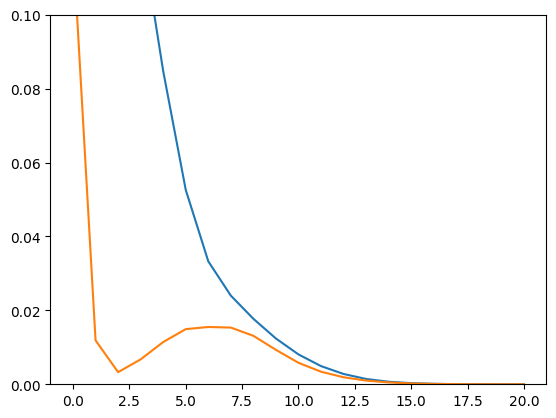

In [45]:
import matplotlib.pyplot as plt
plt.plot(target_losses)
plt.plot(model_losses)
plt.ylim([0, 0.1])
plt.show()